<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [171]:
import pandas as pd
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('../data/clean_text.csv')

In [28]:
df_prices = pd.read_csv('../data/train/tickers_train.csv')
df_prices = df_prices[df_prices['ticker'] == 'ETH'].copy()

In [37]:
df_prices['timestamp'] = pd.to_datetime(df_prices['datetime'])

In [38]:
df_prices['timestamp'] = df_prices['timestamp'].apply(lambda x: x.timestamp())

In [7]:
df = df[df['clean_text'].str.contains('eth')].copy()

In [8]:
tf_idf = TfidfVectorizer()
raw_vectors = tf_idf.fit_transform(df['clean_text'])

In [210]:
raw_vectors.shape

(29788, 18605)

In [211]:
pca = TruncatedSVD(n_components=300)
pca_vectors = pca.fit_transform(raw_vectors)

In [213]:
CLUSTERS_COUNT = 10
clusterizer = KMeans(n_clusters=CLUSTERS_COUNT)
clusters_raw = clusterizer.fit_transform(pca_vectors)

In [214]:
cluster_ind = clusters_raw.argmax(axis=1)

In [215]:
df['cluster'] = cluster_ind

In [216]:
df_prices['change'] = df_prices.priceUsd.pct_change().fillna(0)

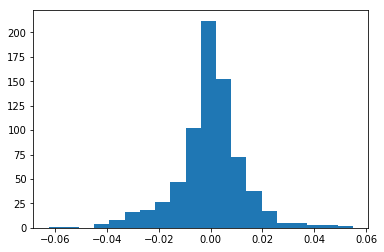

In [217]:
plt.hist(df_prices['change'], bins=20)
plt.show()

In [218]:
df_prices['price_grow'] = df_prices['change'] > 0.005

In [219]:
df_prices['price_grow'].value_counts()

False    510
True     222
Name: price_grow, dtype: int64

In [220]:
WINDOW = 10
cluster_counts = []
target = []
for i, row in df_prices.iterrows():
    ts_end = row['timestamp']
    ts_start = ts_end - WINDOW * 2 * 3600
    clusters = df[(df['timestamp'] > ts_start) & (df['timestamp'] < ts_end)]['cluster'].values
    counter = Counter(clusters)
    row_cluster_counts = [counter[cluster] for cluster in range(CLUSTERS_COUNT)]
    cluster_counts.append(row_cluster_counts)
    target.append(int(row['price_grow']))

In [221]:
test_size = int(len(target) * 0.1)

In [222]:
# model = LogisticRegression()

model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])
model.fit(cluster_counts[:-test_size], target[:-test_size])

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [223]:
test_target_pred = model.predict_proba(cluster_counts[-test_size:])[:, 1]

In [224]:
roc_auc_score(target[-test_size:], test_target_pred)

0.5945833333333334

In [225]:
m = model.steps[1][1]

In [226]:
cluster_counts = df['cluster'].value_counts()

In [227]:
data = []
for i, coef in enumerate(m.coef_[0]):
    data.append([
        i, coef, cluster_counts.get(i, 0)
    ])

In [228]:
d = pd.DataFrame(data, columns=['cluster_no', 'coef', 'count'])

In [229]:
d.sort_values('coef')[:5]

,cluster_no,coef,count
9,9,-0.286567,4082
1,1,-0.167515,5
0,0,-0.099580,16
3,3,-0.032265,4
2,2,0.000000,0


In [236]:
GROW_CLUSTER = d.sort_values('coef').iloc[0]['cluster_no']

In [231]:
d.sort_values('coef', ascending=False)[:5]

,cluster_no,coef,count
5,5,0.198383,25677
4,4,0.105895,4
2,2,0.000000,0
6,6,0.000000,0
7,7,0.000000,0


In [237]:
DOWN_CLUSTER = d.sort_values('coef', ascending=False).iloc[0]['cluster_no']

In [238]:
print('GROW')
texts = ''
for text in df[df['cluster'] == GROW_CLUSTER]['text'][:10]:
    texts += text
    print(text)

GROW
mycrypto is working on a feature to send tokens without having eth
also they can keep eth from ico too. 

well, as i think they already sold all eth earned from ico when it peaked
hello, hope you're having an enjoyable day.

i am working on a blockchain+ai project called noiz that's focused on solving ad fraud in the digital advertising inudstry. we're turnning annoying spambot clicks into social impact by linking advertisers, publishers, users and charitable organizations all together in a decentralized network. check out our video here (or below): goo.gl/mkcxtl

we aim to launch our bounty program within the next week. follow us on telegram @ t.me/noizchainenglish to stay in the loop on how you can earn noiz tokens for free.

visit our website noizchain.com for more details and feel free to send us a message at promotions@noizchain.com with any questions you may have.

looking forward to having your help in disrupting the digital ad industry. let's get out there and make some no

In [233]:
# Counter(texts.split()).most_common(50)

In [239]:
print('DOWN')
texts = ''
for text in df[df['cluster'] == DOWN_CLUSTER]['text'][:10]:
    texts += text
    print(text)

DOWN
its promising at daily chart and connected with ethereum, if eth keep up, qsp can only success, dyor
binance may want to keep things under wraps until they’re  legal, but they certainly wouldn’t dedicate an entire tweet to saying something is not happening mentioning xvg specifically if there was something in the works, there would be no purpose in that
free eth giva away here @privateicodrops
i feel something is going to happen sooner... yeah!
is this the next ethereum?😁
relax and focus on somethingelse. this company needs a good year to get established
bet sunerok is working with mindgeek on something that will blow our minds
monetha posted by @binance_channel today
sold my xvg yesterday and now eth rising up, god bless me yihaaa
ok mike i shall be carefully scrutinising the impact of your educational campaigns over the course of the next few months but i remain sceptical whether there is a real use case for the token other than superficial. other influencers who had ico recentl

In [235]:
# Counter(texts.split()).most_common(50)

In [243]:
grow_indexes = clusters_raw[:, 9].argsort()[-20:]
for text in df.iloc[grow_indexes]['text']:
    print(text)

wan/eth or wan/btc ?
better do something else guys
i̇t should be something
only send eth from mew?
there’s something we don’t know !
i don't have ether
anyone know eth ico price
why wan address same as eth?
guys i don t know something
so i send eth tokens?
do i need more ether?
why? i did something wrong?
why? i say something wrong?
was eth a p&d?
did i do something wrong?
or maybe its something else
so i need ether wallet
wan do something like ont
can i send eth from exchange
i only has one ether wallet


In [244]:
DOWN_CLUSTER

5.0

In [245]:
down_indexes = clusters_raw[:, 5].argsort()[-20:]
for text in df.iloc[down_indexes]['text']:
    print(text)

together with ont like we are!
is going down together with btc
its like they all work together
i use ada as a tether
yeah, something like that! lol.
all together on xvg now?😊
i̇t should be something
why? i did something wrong?
wan is better than ethereum
there's something about eos
guys i don t know something
i think there is something else
something like neo, ont, etc
whether xvg will go up
yeah maybe they know something else
u think its something going on?
people using ont as a tether lol
why? i say something wrong?
even tether is down lol
i think because of tether lol
